<a href="https://colab.research.google.com/github/aricahyasaputra/data-sains-course-assigment-/blob/main/Quiz/Quiz_Minggu_12_Vector_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Support Vector Regression (SVR)</center>
---
SVR memberi fleksibilitas untuk menentukan seberapa besar kesalahan yang dapat diterima dalam model dan akan menemukan garis yang sesuai (atau hyperplane dalam dimensi yang lebih tinggi) agar sesuai dengan data.
Berbeda dengan Least Square biasa, fungsi tujuan SVR adalah untuk meminimalkan koefisien — lebih khusus lagi, l2-norm vektor koefisien — bukan squared error.


In [2]:
# Mengimpor libraries yang diperlukan

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 

### Membaca Data
---

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/aricahyasaputra/data-sains-course-assigment-/main/Quiz/day_wise.csv")

# melihat dataset
df.head()

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13


### Eksplorasi Data
---
Eksplorasi deskriptif data yang diunduh.

In [4]:
# merangkum data
df.describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
count,1.880000e+02,188.000000,1.880000e+02,1.880000e+02,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,4.406960e+06,230770.760638,2.066001e+06,2.110188e+06,87771.021277,3478.824468,50362.015957,4.860638,34.343936,22.104521,144.351064
std,4.757988e+06,217929.094183,2.627976e+06,1.969670e+06,75295.293255,2537.735652,56090.892479,1.579541,16.206159,22.568307,65.175979
min,5.550000e+02,17.000000,2.800000e+01,5.100000e+02,0.000000,0.000000,0.000000,2.040000,1.710000,6.260000,6.000000
25%,1.121910e+05,3935.000000,6.044125e+04,5.864175e+04,5568.500000,250.750000,2488.250000,3.510000,22.785000,9.650000,101.250000
50%,2.848733e+06,204190.000000,7.847840e+05,1.859759e+06,81114.000000,4116.000000,30991.500000,4.850000,35.680000,15.380000,184.000000
75%,7.422046e+06,418634.500000,3.416396e+06,3.587015e+06,131502.500000,5346.000000,79706.250000,6.297500,48.945000,25.342500,187.000000
max,1.648048e+07,654036.000000,9.468087e+06,6.358362e+06,282756.000000,9966.000000,284394.000000,7.180000,57.450000,134.430000,187.000000


Beberapa fitur dapat dieksplorasi dengan cara berikut.

In [5]:
cdf = df[['Confirmed', 'Deaths','Recovered','Active']]
cdf.head(10)

,Confirmed,Deaths,Recovered,Active
0,555,17,28,510
1,654,18,30,606
2,941,26,36,879
3,1434,42,39,1353
4,2118,56,52,2010
5,2927,82,61,2784
6,5578,131,107,5340
7,6166,133,125,5908
8,8234,171,141,7922
9,9927,213,219,9495


Fitur-fitur tersebut dapat diplot sebagai berikut:

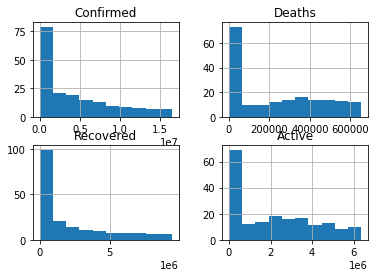

In [6]:
viz = cdf[['Confirmed', 'Deaths','Recovered','Active']]
viz.hist()
plt.show()

Plot fitur-fitur vs emisi dapat dibuat dan dapat dilihat linearitas hubungannya.

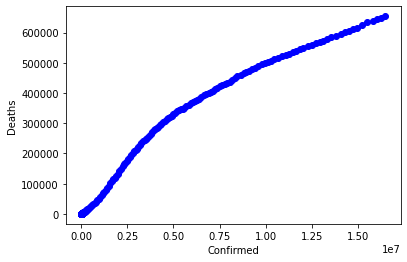

In [7]:
plt.scatter(cdf.Confirmed, cdf.Deaths,  color='blue')
plt.xlabel("Confirmed")
plt.ylabel("Deaths")
plt.show()

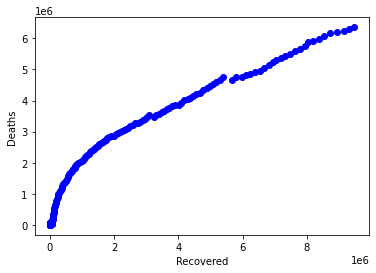

In [8]:
plt.scatter(cdf.Recovered, cdf.Active,  color='blue')
plt.xlabel("Recovered")
plt.ylabel("Deaths")
plt.show()

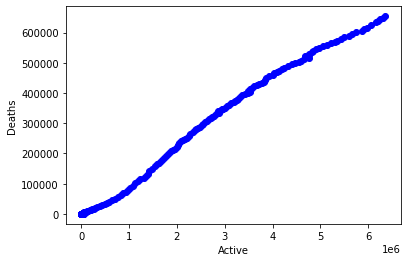

In [9]:
plt.scatter(cdf.Active, cdf.Deaths,  color='blue')
plt.xlabel("Active")
plt.ylabel("Deaths")
plt.show()

#### Pembuatan dataset pelatihan dan pengujian
Pemisahan data latih/uji melibatkan pemisahan dataset menjadi dataset pelatihan dan pengujian, yang saling eksklusif. Setelah itu, dataset pelatihan dapat digunakan untuk membuat model dan dataset pengujian untuk pengujian.
Hal ini akan memberikan evaluasi yang lebih akurat pada akurasi out-of-sample karena dataset pengujian bukan merupakan bagian dari dataset yang telah digunakan untuk melatih data. Ini lebih realistis untuk masalah dunia nyata.

Ini berarti bahwa hasil dari setiap titik data dalam kumpulan data ini diketahui, sehingga sangat bagus untuk data pengujian. Dataset pengujian belum digunakan untuk melatih model, sehingga model tidak memiliki pengetahuan tentang hasil dari data ini, sehingga dapat disebut pengujian di luar sampel.



In [26]:
# Mengambil "Confirmed" sebagai variabel independen (regressor)
X = cdf.iloc[:, 0].values
# Mengambil "Deaths" sebagai variabel dependen
y = cdf.iloc[:, 3].values
# Reshape data karena hanya menggunakan satu fitur "Recovered"
X = X.reshape(-1,1)
# Reshape data karena hanya satu fitur
y = y.reshape(-1,1)

Proses splitting dataset pelatihan dan pengujian

In [27]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Normalisasi atau scaling dataset

In [28]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [20]:
y = np.ravel(y)

In [29]:
y

array([[-1.07394177],
       [-1.0738929 ],
       [-1.07375392],
       [-1.07351263],
       [-1.07317818],
       [-1.07278418],
       [-1.07148303],
       [-1.07119389],
       [-1.07016865],
       [-1.06936791],
       [-1.06834827],
       [-1.06607381],
       [-1.06460214],
       [-1.06270438],
       [-1.06096189],
       [-1.05956606],
       [-1.05805824],
       [-1.0569994 ],
       [-1.05580822],
       [-1.05490515],
       [-1.05427443],
       [-1.05353681],
       [-1.04726984],
       [-1.04490324],
       [-1.04457592],
       [-1.04427405],
       [-1.04416919],
       [-1.04421398],
       [-1.04492411],
       [-1.04571366],
       [-1.0456994 ],
       [-1.04688499],
       [-1.04695728],
       [-1.0476389 ],
       [-1.04857149],
       [-1.04934627],
       [-1.05012055],
       [-1.05117276],
       [-1.05177446],
       [-1.05206157],
       [-1.05256655],
       [-1.05261441],
       [-1.05298805],
       [-1.05294733],
       [-1.05203205],
       [-1

Pembuatan Model

In [30]:
# Fitting SVR to the dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'linear')
#linear = Linear Kernel
regressor.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='linear')

Prediksi nilai baru dengan model yang telah dibentuk

In [35]:
# Predicting a new result

y_pred = regressor.predict(sc_X.transform(np.array([[5.4]])))
#To transform 5.4 to the scaled X value, we first need to convert it into the array form
#Since the transform method of StandardScaler Library only accepts arrays

y_pred = sc_y.inverse_transform(y_pred)
#Now the prediction gives us the scaled value of y
#Thus we need inverse transformation of the scaled value for the real results

print(y_pred)

ValueError: ignored

Visualisasi Hasil (masih dalam nilai yang discaling):

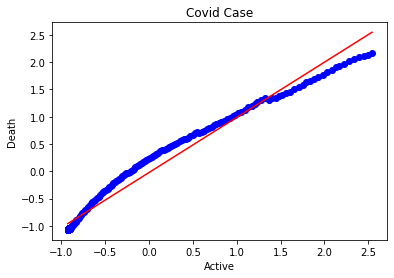

In [18]:
# Visualising the SVR results
plt.scatter(X, y, color = 'blue')
plt.plot(X, regressor.predict(X), color = 'red')
plt.title('Covid Case')
plt.xlabel('Active')
plt.ylabel('Death')
plt.show()

Visualisasi Hasil dalam nilai asalnya:

In [19]:
# Visualising the SVR results
plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'blue')
plt.plot(sc_X.inverse_transform(X), sc_y.inverse_transform(regressor.predict(X)), color = 'red')
plt.title('Covid Case')
plt.xlabel('Active')
plt.ylabel('Death')
plt.show()

ValueError: ignored

#### Evaluasi
Nilai aktual dan nilai prediksi dapat dibandingkan untuk menghitung akurasi dari model regresi. Metrik evaluasi sangat penting untuk pengembangan model karena memberikan pengetahuan untuk perbaikan model.

Ada berbagai metrik untuk evaluasi model, misalnya MSE sebagai error untuk mengetahui akurasi dari model yang dibangun yang dihitung dari MSE model terhadap data pengujian: 
    - Mean Absolute Error (MAE): Rerata dari nilai absolut dari error. MAE adalah metrik paling mudah dipahami karena hanya rata-rata dari error.
    - Mean Squared Error (MSE): adalah rerata dari error dikuadratkan. MSE lebih populer dibanding MAE karena fokus pada error yang besar karena dikuadratkan sehingga berdampak lebih besar terhadap error yang lebih besar dibandingkan error yang lebih kecil.
    - Root Mean Squared Error (RMSE).
    - R-squared bukan error namun metrik yang populer yang merepresentasikan sejauh mana data cocok dengan garis regresi yang didapatkan. Semakin besar R-squared akan semaki baik pencocokan garis terhadap data. Nilai terbaik adalah 1.0 dan dapat bernilai negatif.


In [39]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(cdf[['Active']])
test_y = np.asanyarray(cdf[['Deaths']])
test_y_ = sc_y.inverse_transform(regressor.predict(sc_X.transform(test_x)))

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

ValueError: ignored